# Single Image Rendering

This notebook demonstrates how to solve the Radiative Transfer using SHDOM and render a single image. 

The image rendered is monochromatic - a single wavelength for which a mie table was previously calculated.

---

Related tutorials: 
 - Make Mie Table.ipynb - how to create mie tables
 - Multispectral Rendering.ipynb - how to create RGB (multispectral) images
 - Multiview Rendering.ipynb - how to create multi-view images

---

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np

import shdom

In [3]:
""" 
MiePolydisperse object loads a previously saved mie table.

Rayleigh object initilizes Rayleigh scattering according to a temperature profile.
Temperature profile here is of summer mid-latitude for 0-20km taken from AFGL.

Load a Large-Eddy-Simulated cloud michrophysical properties from a csv file.
"""
# Generate a Microphysical medium
droplets = shdom.MicrophysicalMedium()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/32x36x25.txt', veff=0.1)

# Mie scattering for water droplets
mie = shdom.MiePolydisperse()
mie.read_table(file_path='../mie_tables/polydisperse/Water_672nm.scat')
mie.set_microphysical_medium(droplets)

# Rayleigh scattering for air molecules
temperatures = np.array([292.220, 292.040, 291.860, 291.680, 291.500, 291.320, 291.140, 290.960, 290.780, 
                         290.600, 290.420, 290.240, 290.060, 289.880, 289.700, 289.920, 290.140, 290.360, 
                         290.580, 290.800, 291.020, 291.240, 291.460, 291.680, 291.900])
air_molecules_grid = shdom.Grid(z=np.linspace(0.0, 20.0, len(temperatures)))
temperature_profile = shdom.GridData(air_molecules_grid, temperatures)
rayleigh = shdom.Rayleigh(wavelength=0.672)
rayleigh.set_profile(temperature_profile)

Reading mie table from file: ../mie_tables/polydisperse/Water_672nm.scat


In [4]:
"""
Generate an OpticalMedium with two type of scatterers and initilize an RteSolver object. 
This will initialize all of shdom internal structures and grids.

SceneParameters() contains parameters such as surface albedo and solar radiance
NumericalParameters() contains parameters such as number of angular bins and split cell ratio.
All parameters have default values which can be viewed using print(params.info).
"""
atmospheric_grid = droplets.grid + air_molecules_grid
atmosphere = shdom.OpticalMedium(atmospheric_grid)
atmosphere.add_scatterer(mie.get_scatterer(), name='droplets')
atmosphere.add_scatterer(rayleigh.get_scatterer(), name='air')

numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
    wavelength=0.672,
    source=shdom.SolarSource(azimuth=65, zenith=135)
)

rte_solver = shdom.RteSolver(scene_params, numerical_params)
rte_solver.init_medium(atmosphere)

print(rte_solver.info)

Scene Parameters: 
   Wavelength: [0.672 micron]
   Surface: [Lambertian, albedo: 0.05]
   Source: [Solar, flux: 1.0, azimuth: 65deg, zenith: 135deg]
   Boundary Conditions: [x:open, y:open]

Numerical Parameters: 
   acceleration_flag: True
   adapt_grid_factor: 5
   deltam: True
   cell_to_point_ratio: 1.5
   num_mu_bins: 8
   high_order_radiance: True
   max_total_mb: 10000.0
   solution_accuracy: 0.0001
   spherical_harmonics_accuracy: 0.01
   split_accuracy: 0.1
   num_phi_bins: 16
   num_sh_term_factor: 5



In [5]:
"""
Solve the Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).
The outputs are the source function (J) and radiance field (I) which are stored in 
the shdom.RteSolver object. These are subsequently used for the rendering of an image.
"""
rte_solver.solve(maxiter=100)

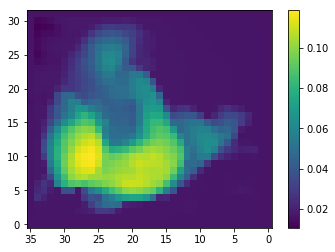

In [6]:
projection = shdom.OrthographicProjection(
    bounding_box=droplets.grid.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)
camera = shdom.Camera(shdom.RadianceSensor(), projection)
image = camera.render(rte_solver)

%matplotlib inline
plt.imshow(image)
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis() 
plt.colorbar()